In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import timedelta
from pandas.io.gbq import read_gbq
import geopandas as gpd
import fiona
import shapely
import rtree
import pylab as pl

#### Using the NYC taxi data from the period before July 2016:

#### Analysis questions:
#### How would you assess the efficiency of aggregating rides within Astoria? From Astoria to Manhattan? From LaGuardia airport, through Astoria, to Manhattan and back?
#### How does this compare to rides within Manhattan?
#### Would you provide ride shares only within Astoria as new service or also between Astoria and Manhattan? Why?
#### Would you launch Astoria service during all our hours of operation (24/7) or only for certain hours? If so - which hours?

In [4]:
#load NYC open data neighbourhood shapefile to find neighbourhoods

hoods = gpd.GeoDataFrame.from_file("geojsondata/NYCneighbourhood.geojson")

In [5]:
#setting crs and geometry of hoods dataframe

hoods.crs = fiona.crs.from_epsg(4326)
hoods = hoods.set_geometry('geometry')

In [6]:
hoods.head()

,@id,borough,boroughCode,geometry,neighborhood
0,http://nyc.pediacities.com/Resource/Neighborho...,Bronx,2,POLYGON ((-73.84859700000018 40.87167000000012...,Allerton
1,http://nyc.pediacities.com/Resource/Neighborho...,Queens,4,"POLYGON ((-73.74333268196389 40.7388830992604,...",Alley Pond Park
2,http://nyc.pediacities.com/Resource/Neighborho...,Staten Island,5,"POLYGON ((-74.169827 40.56107800000017, -74.16...",Arden Heights
3,http://nyc.pediacities.com/Resource/Neighborho...,Staten Island,5,POLYGON ((-74.15974815874296 40.64141652579018...,Arlington
4,http://nyc.pediacities.com/Resource/Neighborho...,Staten Island,5,POLYGON ((-74.06077989345394 40.59318800468343...,Arrochar


In [238]:
#finding relevant polygons for latitide/longitude analysis

Astoria = hoods.loc[hoods['neighborhood']=='Astoria']
Manhattan = hoods.loc[hoods['borough']=='Manhattan']
LaGuardia = hoods.loc[hoods['neighborhood']=='LaGuardia Airport']

In [239]:
#concantenating into new, simplified geo dataframe 

relevant = [Astoria, LaGuardia, Manhattan]
sub_hoods = pd.concat(relevant)
sub_hoods.reset_index(drop=True, inplace=True)

In [240]:
#setting dataframe as Geopandas Dataframe, CRS type and geometry column

sub_hoods = gpd.GeoDataFrame(sub_hoods)
sub_hoods.crs = fiona.crs.from_epsg(4326)
sub_hoods = sub_hoods.set_geometry('geometry')

In [241]:
sub_hoods.head()

,@id,borough,boroughCode,geometry,neighborhood
0,http://nyc.pediacities.com/Resource/Neighborho...,Queens,4,POLYGON ((-73.90160305064738 40.76777029715587...,Astoria
1,http://nyc.pediacities.com/Resource/Neighborho...,Queens,4,POLYGON ((-73.85960740237437 40.76272137770127...,LaGuardia Airport
2,http://nyc.pediacities.com/Resource/Neighborho...,Manhattan,1,"POLYGON ((-74.01375400000018 40.71369, -74.014...",Battery Park City
3,http://nyc.pediacities.com/Resource/Neighborho...,Manhattan,1,POLYGON ((-73.94965699268657 40.79706872127114...,Central Park
4,http://nyc.pediacities.com/Resource/Neighborho...,Manhattan,1,POLYGON ((-73.99346400122367 40.75218999709955...,Chelsea


In [457]:
#SQL query of green taxis in 2015 inside astoria and laguardia lat/lon bounds, 
#this is to maximize targeted queries, limit 500,000

project = "spheric-crow-161317"
sample_query = "SELECT pickup_datetime, dropoff_datetime, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, passenger_count, trip_distance  FROM `bigquery-public-data.new_york.tlc_green_trips_2015` WHERE (round(dropoff_longitude, 4) between -73.9444 and -73.8539 and round(dropoff_latitude, 4) between 40.4733 and 40.7908) or (round(pickup_longitude, 4) between -73.944 and -73.8539 and round(pickup_latitude, 4) between 40.4733 and 40.7908) LIMIT 500000"
         
g_15_q = read_gbq(query=sample_query, project_id=project, dialect='standard')

Requesting query... ok.
Query running...
Query done.
Cache hit.

Retrieving results...
  Got page: 2; 18.0% done. Elapsed 13.22 s.
  Got page: 3; 26.0% done. Elapsed 19.47 s.
  Got page: 4; 35.0% done. Elapsed 27.16 s.
  Got page: 5; 44.0% done. Elapsed 34.59 s.
  Got page: 6; 53.0% done. Elapsed 42.45 s.
  Got page: 7; 61.0% done. Elapsed 50.58 s.
  Got page: 8; 70.0% done. Elapsed 60.78 s.
  Got page: 9; 79.0% done. Elapsed 67.76 s.
  Got page: 10; 88.0% done. Elapsed 74.13 s.
  Got page: 11; 96.0% done. Elapsed 80.72 s.
  Got page: 12; 100.0% done. Elapsed 85.5 s.
Got 500000 rows.

Total time taken 115.43 s.
Finished at 2017-05-29 19:03:27.


In [444]:
#SQL query of yellow taxis in 2015 inside astoria and laguardia lat/lon bounds, 
#this is to maximize targeted queries, limit 500,000

project = "spheric-crow-161317"
sample_query = "SELECT pickup_datetime, dropoff_datetime, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, passenger_count, trip_distance  FROM `bigquery-public-data.new_york.tlc_yellow_trips_2015` WHERE (round(dropoff_longitude, 4) between -73.9444 and -73.8539 and round(dropoff_latitude, 4) between 40.4733 and 40.7908) or (round(pickup_longitude, 4) between -73.944 and -73.8539 and round(pickup_latitude, 4) between 40.4733 and 40.7908) LIMIT 500000"
         
y_15_q = read_gbq(query=sample_query, project_id=project, dialect='standard')

Requesting query... ok.
Query running...
Query done.
Cache hit.

Retrieving results...
  Got page: 1; 9.0% done. Elapsed 8.44 s.
  Got page: 2; 18.0% done. Elapsed 17.68 s.
  Got page: 3; 26.0% done. Elapsed 25.62 s.
  Got page: 4; 35.0% done. Elapsed 32.23 s.
  Got page: 5; 44.0% done. Elapsed 39.49 s.
  Got page: 6; 53.0% done. Elapsed 46.04 s.
  Got page: 7; 61.0% done. Elapsed 53.07 s.
  Got page: 8; 70.0% done. Elapsed 59.83 s.
  Got page: 9; 79.0% done. Elapsed 66.45 s.
  Got page: 10; 88.0% done. Elapsed 75.08 s.
  Got page: 11; 96.0% done. Elapsed 87.24 s.
  Got page: 12; 100.0% done. Elapsed 91.34 s.
Got 500000 rows.

Total time taken 122.44 s.
Finished at 2017-05-29 18:56:56.


In [445]:
#SQL query of green taxis in 2015 inside Manhattan, Upper East Side lat/lon bounds, 
# this is to maximize targeted queries, limit 10,000

project = "spheric-crow-161317"
ues_query = "SELECT pickup_datetime, dropoff_datetime, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, passenger_count, trip_distance  FROM `bigquery-public-data.new_york.tlc_green_trips_2015` WHERE (round(dropoff_longitude, 4) between -73.9727 and -73.9435 and round(dropoff_latitude, 4) between 40.7608 and 40.7821) or (round(pickup_longitude, 4) between -73.9727 and -73.9435 and round(pickup_latitude, 4) between 40.7608 and 40.7821) LIMIT 10000"
         
g_15_ues = read_gbq(query=ues_query, project_id=project, dialect='standard')

Requesting query... ok.
Query running...
Query done.
Cache hit.

Retrieving results...
Got 10000 rows.

Total time taken 5.45 s.
Finished at 2017-05-29 18:57:05.


In [446]:
#UES Yellow Taxi 2015 query

project = "spheric-crow-161317"
ues_query = "SELECT pickup_datetime, dropoff_datetime, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, passenger_count, trip_distance  FROM `bigquery-public-data.new_york.tlc_yellow_trips_2015` WHERE (round(dropoff_longitude, 4) between -73.9727 and -73.9435 and round(dropoff_latitude, 4) between 40.7608 and 40.7821) or (round(pickup_longitude, 4) between -73.9727 and -73.9435 and round(pickup_latitude, 4) between 40.7608 and 40.7821) LIMIT 10000"
         
y_15_ues = read_gbq(query=ues_query, project_id=project, dialect='standard')

Requesting query... ok.
Query running...
Query done.
Cache hit.

Retrieving results...
Got 10000 rows.

Total time taken 4.84 s.
Finished at 2017-05-29 18:57:13.


In [447]:
#green 2015 midtown query, limit 20000

project = "spheric-crow-161317"
mid_query = "SELECT pickup_datetime, dropoff_datetime, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, passenger_count, trip_distance  FROM `bigquery-public-data.new_york.tlc_green_trips_2015` WHERE (round(dropoff_longitude, 4) between -74.0096 and -73.9623 and round(dropoff_latitude, 4) between 40.7390 and 40.7659) or (round(pickup_longitude, 4) between -74.0096 and -73.9623 and round(pickup_latitude, 4) between 40.7390 and 40.7659) LIMIT 20000"

g_15_mid = read_gbq(query=mid_query, project_id=project, dialect='standard')

Requesting query... ok.
Query running...
Query done.
Cache hit.

Retrieving results...
Got 20000 rows.

Total time taken 7.19 s.
Finished at 2017-05-29 18:57:24.


In [448]:
#yellow 2015 midtown query, limit 20000

project = "spheric-crow-161317"
mid_query = "SELECT pickup_datetime, dropoff_datetime, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, passenger_count, trip_distance  FROM `bigquery-public-data.new_york.tlc_yellow_trips_2015` WHERE (round(dropoff_longitude, 4) between -74.0096 and -73.9623 and round(dropoff_latitude, 4) between 40.7390 and 40.7659) or (round(pickup_longitude, 4) between -74.0096 and -73.9623 and round(pickup_latitude, 4) between 40.7390 and 40.7659) LIMIT 20000"

y_15_mid = read_gbq(query=mid_query, project_id=project, dialect='standard')

Requesting query... ok.
Query running...
Query done.
Cache hit.

Retrieving results...
Got 20000 rows.

Total time taken 6.68 s.
Finished at 2017-05-29 18:57:33.


In [521]:
#combining Manhattan queries by taxi color, adding a column to indicate taxi color, 
#combining into Manhattan 2015 dataframe with 60,000 entries

man_y_15 = pd.concat([y_15_mid, y_15_ues])
man_g_15 = pd.concat([g_15_mid, g_15_ues])
man_y_15['color'] = 'y'
man_g_15['color'] = 'g'
man_15 = pd.concat([man_y_15, man_g_15])
man_15 = man_15.reset_index(drop=True)

In [453]:
#distance on earth based on longitude and latitude
#I pulled this from stack overflow, but converted to miles: https://stackoverflow.com/questions/15736995/how-can-i-quickly-estimate-the-distance-between-two-latitude-longitude-points

def haversine(lon1, lat1, lon2, lat2):
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6367 * c
    mi = km * 0.621371
    return mi

In [473]:
#this function calculates the distance between the pickup and dropoff location
#appends it to the dataframe as a column 
#calculates the difference between the optimal and actual distance and 
#appends to the dataframe as a column

def distance_func(j):
    listj = []
    for z in range(len(j)):
        i=0
        i = haversine(j['pickup_longitude'][z], j['pickup_latitude'][z], j['dropoff_longitude'][z], j['dropoff_latitude'][z])
        listj.append(i)
    j['optimal_distance'] = listj
    j['distance_difference'] = j['trip_distance'] - j['optimal_distance']
    return j

In [474]:
g_15_q = distance_func(g_15_q)
y_15_q = distance_func(y_15_q)
man_15 = distance_func(man_15)

In [478]:
#function creating shapely geo point in queried dataframe,
#returning as geo dataframe with defined CRS

def geopoints(j):
    j.dropna(axis=0, subset=['pickup_latitude','pickup_longitude'], inplace=True)
    j['pickup_lonlat'] = zip(j.pickup_longitude, j.pickup_latitude)
    j['dropoff_lonlat'] = zip(j.dropoff_longitude, j.dropoff_latitude)
    j['pickup_geometry'] = j[['pickup_lonlat']].applymap(lambda x:shapely.geometry.Point(x))
    j['dropoff_geometry'] = j[['dropoff_lonlat']].applymap(lambda x:shapely.geometry.Point(x))
    j = gpd.GeoDataFrame(j)
    j.crs = fiona.crs.from_epsg(4326)
    return j

In [479]:
g_15_q = geopoints(g_15_q)
y_15_q = geopoints(y_15_q)
man_15 = geopoints(man_15)

In [526]:
#rearrange columns for later use in function

man_15 = man_15[[u'pickup_datetime', u'dropoff_datetime', u'pickup_longitude',
       u'pickup_latitude', u'dropoff_longitude', u'dropoff_latitude',
       u'passenger_count', u'trip_distance', u'optimal_distance',
       u'distance_difference', u'pickup_lonlat', u'dropoff_lonlat',
       u'pickup_geometry', u'dropoff_geometry', u'color']]

In [488]:
#function putting pickup geometry into a new dataframes, setting it as GeoDataFrame 
#setting their CRS, column names & geometry 
#this function returns a dataframe, with the pickup neighbourhoods and boroughs

def geopointpickup(j):
    df_pickup = j['pickup_geometry'].to_frame()
    df_pickup = gpd.GeoDataFrame(df_pickup)
    df_pickup.crs = fiona.crs.from_epsg(4326)
    df_pickup.columns.values[0] = 'geometry'
    df_pickup = df_pickup.set_geometry('geometry')
    pickup_hood = gpd.sjoin(df_pickup, sub_hoods, how="left", op="intersects")
    bye = [1,2,4]
    pickup_hood = pickup_hood.drop(pickup_hood.columns[bye],axis=1)
    pickup_hood.columns = ['pickup_geometry', 'pickup_borough','pickup_hood']
    return pickup_hood

In [487]:
#dropoff version of the above function

def geopointdropoff(j):
    df_dropoff = j['dropoff_geometry'].to_frame()
    df_dropoff = gpd.GeoDataFrame(df_dropoff)
    df_dropoff.crs = fiona.crs.from_epsg(4326)
    df_dropoff.columns.values[0] = 'geometry'
    df_dropoff = df_dropoff.set_geometry('geometry')
    dropoff_hood = gpd.sjoin(df_dropoff, sub_hoods, how="left", op="intersects")
    bye = [1,2,4]
    dropoff_hood = dropoff_hood.drop(dropoff_hood.columns[bye],axis=1)
    dropoff_hood.columns = ['dropoff_geometry', 'dropoff_borough','dropoff_hood']
    return dropoff_hood

In [489]:
pickup_hood_g = geopointpickup(g_15_q)
dropoff_hood_g = geopointdropoff(g_15_q)

In [490]:
pickup_hood_y = geopointpickup(y_15_q)
dropoff_hood_y = geopointdropoff(y_15_q)

In [527]:
pickup_hood_m = geopointpickup(man_15)
dropoff_hood_m = geopointdropoff(man_15)

In [506]:
def drop_concat(j, pickup_hood, dropoff_hood):
    bye2 = [2,3,4,5,10,11,12,13]
    j = j.drop(j.columns[bye2],axis=1) 
    j = pd.concat([j, pickup_hood, dropoff_hood], axis=1, join_axes=[j.index])
    j = j.dropna()
    j = j.reset_index(drop=True)
    return j

In [496]:
g_15_q = drop_concat(g_15_q, pickup_hood_g, dropoff_hood_g)

In [497]:
y_15_q = drop_concat(y_15_q, pickup_hood_y, dropoff_hood_y)

In [528]:
man_15 = drop_concat(man_15, pickup_hood_m, dropoff_hood_m)

In [530]:
#rearranging columns for later use

man_15 = man_15[[u'pickup_datetime', u'dropoff_datetime', u'passenger_count',
       u'trip_distance', u'optimal_distance', u'distance_difference',
       u'pickup_geometry', u'pickup_borough', u'pickup_hood',
       u'dropoff_geometry', u'dropoff_borough', u'dropoff_hood', u'color']]

In [258]:
#we've lost the most values from the Queens green taxi query ~90%
#I'm guessing most rides to and from Astoria/LaGuardia 
#don't go to Manhattan or stay in the area

g_15_q.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 50457 entries, 4 to 499998
Data columns (total 10 columns):
pickup_datetime     50457 non-null datetime64[ns]
dropoff_datetime    50457 non-null datetime64[ns]
passenger_count     50457 non-null int64
trip_distance       50457 non-null float64
pickup_geometry     50457 non-null object
pickup_borough      50457 non-null object
pickup_hood         50457 non-null object
dropoff_geometry    50457 non-null object
dropoff_borough     50457 non-null object
dropoff_hood        50457 non-null object
dtypes: datetime64[ns](2), float64(1), int64(1), object(6)
memory usage: 4.2+ MB


In [286]:
#we only lost about half of the queens yellow taxi query
#yellow taxis make more trips in and around Manhattan-Astoria/Laguardia than green taxis

y_15_q.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 250332 entries, 0 to 499999
Data columns (total 10 columns):
pickup_datetime     250332 non-null datetime64[ns]
dropoff_datetime    250332 non-null datetime64[ns]
passenger_count     250332 non-null int64
trip_distance       250332 non-null float64
pickup_geometry     250332 non-null object
pickup_borough      250332 non-null object
pickup_hood         250332 non-null object
dropoff_geometry    250332 non-null object
dropoff_borough     250332 non-null object
dropoff_hood        250332 non-null object
dtypes: datetime64[ns](2), float64(1), int64(1), object(6)
memory usage: 21.0+ MB


In [532]:
#we kept 75% of the Manhattan query
#Manhattan is, after all, the most popular destination in NYC

man_15.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45216 entries, 0 to 45215
Data columns (total 13 columns):
pickup_datetime        45216 non-null datetime64[ns]
dropoff_datetime       45216 non-null datetime64[ns]
passenger_count        45216 non-null int64
trip_distance          45216 non-null float64
optimal_distance       45216 non-null float64
distance_difference    45216 non-null float64
pickup_geometry        45216 non-null object
pickup_borough         45216 non-null object
pickup_hood            45216 non-null object
dropoff_geometry       45216 non-null object
dropoff_borough        45216 non-null object
dropoff_hood           45216 non-null object
color                  45216 non-null object
dtypes: datetime64[ns](2), float64(3), int64(1), object(7)
memory usage: 4.5+ MB


In [509]:
#making full queens 2015 dataframe with column that indicates yellow or green taxis

y_15_q['color'] = 'y'
g_15_q['color'] = 'g'
que_15= pd.concat([y_15_q, g_15_q])
que_15 = que_15.reset_index(drop=True)

In [534]:
#making full NYC dataframe

nyc_15 = pd.concat([que_15, man_15])
nyc_15 = nyc_15.reset_index(drop=True)

In [536]:
#finding length of ride in timedelta and seconds

def time_sec(j):
    j["time"] = j['dropoff_datetime'] - j['pickup_datetime']
    j['seconds']=j['time'].dt.total_seconds()

In [540]:
time_sec(nyc_15)

In [555]:
#trying to get rid of bogus rows by looking at for negative differences in distance

nyc_15.sort_values(by="distance_difference", ascending=True, kind='quicksort').head()

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,optimal_distance,distance_difference,pickup_geometry,pickup_borough,pickup_hood,dropoff_geometry,dropoff_borough,dropoff_hood,color,time,seconds
169758,2015-05-28 07:41:07,2015-05-28 08:22:22,1,0.10,9.133284,-9.033284,POINT (-74.01726531982422 40.70522689819336),Manhattan,Battery Park City,POINT (-73.86582946777344 40.77102661132812),Queens,LaGuardia Airport,y,00:41:15,2475.0
44565,2015-09-10 14:00:53,2015-09-10 14:32:01,1,0.00,8.793494,-8.793494,POINT (-74.01158905029297 40.70280838012695),Manhattan,Financial District,POINT (-73.87261962890625 40.77443695068359),Queens,LaGuardia Airport,y,00:31:08,1868.0
193598,2015-03-23 14:01:54,2015-03-23 15:57:01,1,0.03,8.710319,-8.680319,POINT (-74.00736999511719 40.7052001953125),Manhattan,Financial District,POINT (-73.86479187011719 40.77032852172852),Queens,LaGuardia Airport,y,01:55:07,6907.0
245949,2015-01-21 10:58:26,2015-01-21 11:25:40,1,0.20,8.820529,-8.620529,POINT (-74.01387023925781 40.70661926269531),Manhattan,Financial District,POINT (-73.86949920654297 40.77259063720703),Queens,LaGuardia Airport,y,00:27:14,1634.0
132338,2015-03-28 07:08:38,2015-03-28 07:28:32,1,0.03,8.491658,-8.461658,POINT (-74.01031494140625 40.70973205566406),Manhattan,Financial District,POINT (-73.87221527099609 40.77435302734375),Queens,LaGuardia Airport,y,00:19:54,1194.0


In [575]:
#same for time... looking for trip lengths that are errors or don't make sense

nyc_15.sort_values(by="seconds", ascending=True, kind='quicksort').head()

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,optimal_distance,distance_difference,pickup_geometry,pickup_borough,pickup_hood,dropoff_geometry,dropoff_borough,dropoff_hood,color,time,seconds
168682,2015-11-01 01:57:29,2015-11-01 01:11:41,1,3.80,2.412243,1.387757,POINT (-73.97394561767578 40.75402450561523),Manhattan,Midtown,POINT (-73.93179321289062 40.76820373535156),Queens,Astoria,y,-1 days +23:14:12,-2748.0
336085,2015-11-01 01:44:12,2015-11-01 01:01:51,1,4.50,3.783228,0.716772,POINT (-73.95284271240234 40.7886848449707),Manhattan,East Harlem,POINT (-73.99069213867188 40.74199295043945),Manhattan,Flatiron District,g,-1 days +23:17:39,-2541.0
21265,2015-02-04 00:00:00,2015-02-04 00:00:00,1,10.27,5.931628,4.338372,POINT (-73.87315368652344 40.77402496337891),Queens,LaGuardia Airport,POINT (-73.98488616943359 40.75925064086914),Manhattan,Theater District,y,00:00:00,0.0
144517,2015-06-16 00:14:08,2015-06-16 00:14:08,1,19.20,7.687701,11.512299,POINT (-73.87194061279297 40.77412033081055),Queens,LaGuardia Airport,POINT (-74.00328063964844 40.72416687011719),Manhattan,SoHo,y,00:00:00,0.0
154792,2015-12-04 00:00:00,2015-12-04 00:00:00,1,13.39,5.948067,7.441933,POINT (-73.86628723144531 40.77131271362305),Queens,LaGuardia Airport,POINT (-73.97960662841797 40.76392364501953),Manhattan,Midtown,y,00:00:00,0.0


In [562]:
#dropping rows where distance difference is less than or equal to zero
#dropping trips under 2 minutes, they seem to be in error
#resetting index

nyc_15 = nyc_15.drop(nyc_15[nyc_15.distance_difference <= 0].index)
nyc_15 = nyc_15.drop(nyc_15[nyc_15.seconds < 120].index)
nyc_15 = nyc_15.reset_index(drop=True)

In [628]:
#Speed, Time and Distance are all measures of efficiency. We can deduce all of these
#metrics from the dataframe. To find distance efficiency I'll divide ideal distance by
#actual distance multiplied by the number of passengers
#the best efficiency score is a 6 
#higher numbers are better

nyc_15['distance_efficiency'] = ((nyc_15['optimal_distance']/nyc_15['trip_distance'])*nyc_15['passenger_count']).round(decimals=2)

In [740]:
#Measuring time efficiency by dividing the optimal distance by 55 miles per second
#(55 mph = max nyc speed limit on highways and = 0.0152778 miles per second) 
#then determining time efficiency by dividing the optimal seconds by the actual seconds 
#and multiplying by number of passengers 6 is the highest score

nyc_15['opt_seconds'] = ((nyc_15['optimal_distance']/0.0152778))
nyc_15['time_efficiency'] = ((nyc_15['opt_seconds']/nyc_15['seconds'])*nyc_15['passenger_count'])

In [741]:
nyc_15.head()

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,optimal_distance,distance_difference,pickup_geometry,pickup_borough,pickup_hood,dropoff_geometry,dropoff_borough,dropoff_hood,color,time,seconds,distance_efficiency,timestamp,hour,opt_seconds,time_efficiency
0,2015-11-16 17:17:41,2015-11-16 17:22:23,1,0.69,0.419255,0.270745,POINT (-73.91494750976562 40.75708389282227),Queens,Astoria,POINT (-73.92274475097656 40.75567626953125),Queens,Astoria,y,00:04:42,282.0,0.61,2015-11-16 17:17:41,17,27.442116,0.097312
1,2015-12-06 01:08:19,2015-12-06 01:12:03,1,0.69,0.470044,0.219956,POINT (-73.94174194335938 40.78752517700195),Manhattan,East Harlem,POINT (-73.95065307617188 40.78662109375),Manhattan,East Harlem,y,00:03:44,224.0,0.68,2015-12-06 01:08:19,1,30.766442,0.137350
2,2015-03-15 11:41:26,2015-03-15 11:45:22,1,0.94,0.806225,0.133775,POINT (-73.94306945800781 40.78990173339844),Manhattan,East Harlem,POINT (-73.95272827148438 40.78079986572266),Manhattan,Upper East Side,y,00:03:56,236.0,0.86,2015-03-15 11:41:26,11,52.770982,0.223606
3,2015-03-25 12:46:19,2015-03-25 12:53:05,1,0.94,0.619433,0.320567,POINT (-73.95365142822266 40.77935791015625),Manhattan,Upper East Side,POINT (-73.94387054443359 40.78442001342773),Manhattan,East Harlem,y,00:06:46,406.0,0.66,2015-03-25 12:46:19,12,40.544640,0.099864
4,2015-04-25 18:02:02,2015-04-25 18:06:56,1,1.38,0.865029,0.514971,POINT (-73.95554351806641 40.77961730957031),Manhattan,Upper East Side,POINT (-73.94214630126953 40.78696823120117),Manhattan,East Harlem,y,00:04:54,294.0,0.63,2015-04-25 18:02:02,18,56.619989,0.192585


In [732]:
#segmenting pickup/dropoff hoods

AstoriaAstoria = nyc_15[(nyc_15.pickup_hood == "Astoria") & (nyc_15.pickup_hood == "Astoria")]
AstoriaManhattan = nyc_15[(nyc_15.pickup_hood == "Astoria") & (nyc_15.dropoff_borough == "Manhattan")]
ManhattanAstoria = nyc_15[(nyc_15.pickup_borough == "Manhattan") & (nyc_15.dropoff_hood == "Astoria")]
LaGuardiaManhattan = nyc_15[(nyc_15.pickup_hood == "LaGuardia Airport") & (nyc_15.dropoff_borough == "Manhattan")]
ManhattanLaGuardia = nyc_15[(nyc_15.pickup_borough == "Manhattan") & (nyc_15.dropoff_hood == "LaGuardia Airport")]
Manhattan = nyc_15[(nyc_15.pickup_borough == "Manhattan") & (nyc_15.dropoff_borough == "Manhattan")]

In [733]:
#Within Manhattan and Manhattan to Astoria have the highest efficiency!
#Within Astoria has almost the same efficiency as LaGuardia to Manhattan & Manhattan to Astoria
#Astoria to Manhattan and Manhattan to LaGuardia have the lowest efficiency

print "Astoria-Astoria     distance efficiency: " +str(AstoriaAstoria['distance_efficiency'].mean())
print "Astoria-Manhattan   distance efficiency: " +str(AstoriaManhattan['distance_efficiency'].mean())
print "Manhattan-Astoria   distance efficiency: " +str(ManhattanAstoria['distance_efficiency'].mean())
print "LaGuardia-Manhattan distance efficiency: " +str(LaGuardiaManhattan['distance_efficiency'].mean())
print "Manhattan-LaGuardia distance efficiency: " +str(ManhattanLaGuardia['distance_efficiency'].mean())
print "Manhattan-Manhattan distance efficiency: " +str(Manhattan['distance_efficiency'].mean())

Astoria-Astoria     distance efficiency: 1.05324448807
Astoria-Manhattan   distance efficiency: 0.967497499643
Manhattan-Astoria   distance efficiency: 1.06845787945
LaGuardia-Manhattan distance efficiency: 1.0582277649
Manhattan-LaGuardia distance efficiency: 1.01404122693
Manhattan-Manhattan distance efficiency: 1.1976692365


In [735]:
AAd = AstoriaAstoria['distance_efficiency'].mean()
AMd = AstoriaManhattan['distance_efficiency'].mean()
MAd = ManhattanAstoria['distance_efficiency'].mean()
LMd = LaGuardiaManhattan['distance_efficiency'].mean()
MLd = ManhattanLaGuardia['distance_efficiency'].mean()
MMd = Manhattan['distance_efficiency'].mean()

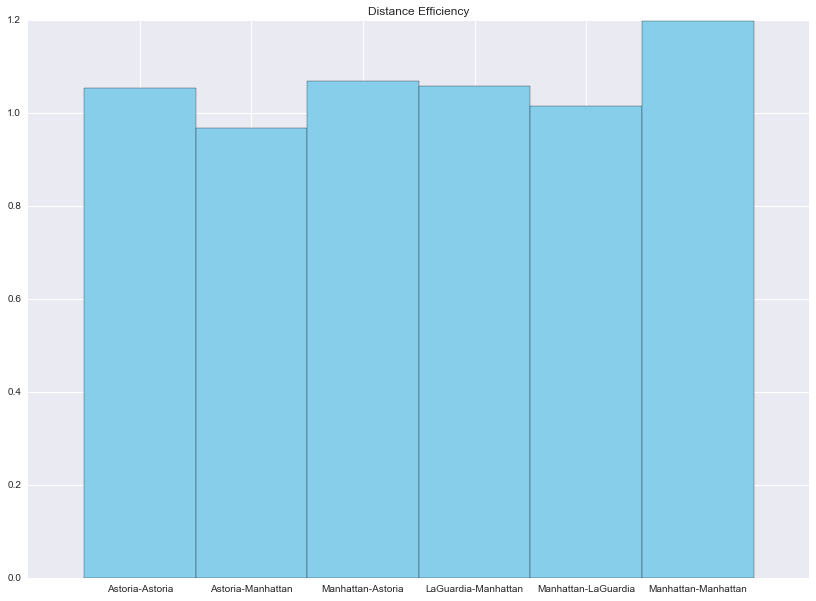

In [737]:
list10 = [("Astoria-Astoria", AAd), ("Astoria-Manhattan", AMd), ("Manhattan-Astoria", MAd),
         ("LaGuardia-Manhattan", LMd), ("Manhattan-LaGuardia", MLd), ("Manhattan-Manhattan", MMd)]
labels, ys = zip(*list10)
xs = np.arange(len(labels)) 
width = 1

fig = plt.figure(figsize=(14,10), dpi=100)
plt.bar(xs, ys, width, align='center', color=["skyblue"])
plt.title('Distance Efficiency')
plt.xticks(xs, labels); 

In [742]:
AstoriaAstoria2 = nyc_15[(nyc_15.pickup_hood == "Astoria") & (nyc_15.pickup_hood == "Astoria")]
AstoriaManhattan2 = nyc_15[(nyc_15.pickup_hood == "Astoria") & (nyc_15.dropoff_borough == "Manhattan")]
ManhattanAstoria2 = nyc_15[(nyc_15.pickup_borough == "Manhattan") & (nyc_15.dropoff_hood == "Astoria")]
LaGuardiaManhattan2 = nyc_15[(nyc_15.pickup_hood == "LaGuardia Airport") & (nyc_15.dropoff_borough == "Manhattan")]
ManhattanLaGuardia2 = nyc_15[(nyc_15.pickup_borough == "Manhattan") & (nyc_15.dropoff_hood == "LaGuardia Airport")]
Manhattan2 = nyc_15[(nyc_15.pickup_borough == "Manhattan") & (nyc_15.dropoff_borough == "Manhattan")]

print "Astoria-Astoria     time efficiency: " +str(AstoriaAstoria2['time_efficiency'].mean())
print "Astoria-Manhattan   time efficiency: " +str(AstoriaManhattan2['time_efficiency'].mean())
print "Manhattan-Astoria   time efficiency: " +str(ManhattanAstoria2['time_efficiency'].mean())
print "LaGuardia-Manhattan time efficiency: " +str(LaGuardiaManhattan2['time_efficiency'].mean())
print "Manhattan-LaGuardia time efficiency: " +str(ManhattanLaGuardia2['time_efficiency'].mean())
print "Manhattan-Manhattan time efficiency: " +str(Manhattan2['time_efficiency'].mean())

Astoria-Astoria     time efficiency: 0.24484451178
Astoria-Manhattan   time efficiency: 0.254953148765
Manhattan-Astoria   time efficiency: 0.30997131178
LaGuardia-Manhattan time efficiency: 0.394857612002
Manhattan-LaGuardia time efficiency: 0.432711342161
Manhattan-Manhattan time efficiency: 0.266934294634


In [743]:
AA = AstoriaAstoria2['time_efficiency'].mean()
AM = AstoriaManhattan2['time_efficiency'].mean()
MA = ManhattanAstoria2['time_efficiency'].mean()
LM = LaGuardiaManhattan2['time_efficiency'].mean()
ML = ManhattanLaGuardia2['time_efficiency'].mean()
MM = Manhattan2['time_efficiency'].mean()

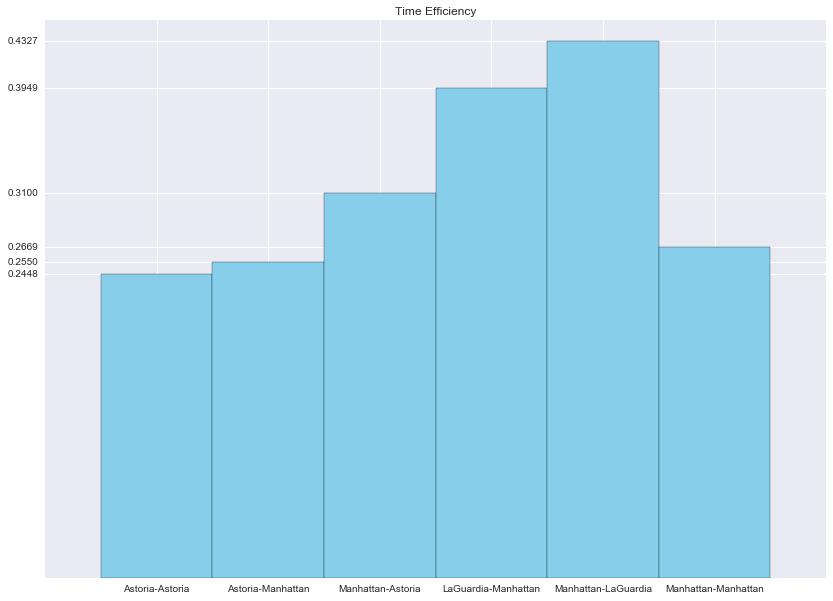

In [744]:
list1 = [("Astoria-Astoria", AA), ("Astoria-Manhattan", AM), ("Manhattan-Astoria", MA),
         ("LaGuardia-Manhattan", LM), ("Manhattan-LaGuardia", ML), ("Manhattan-Manhattan", MM)]
labels, ys = zip(*list1)
xs = np.arange(len(labels)) 
width = 1

fig = plt.figure(figsize=(14,10), dpi=100)
plt.bar(xs, ys, width, align='center', color=["skyblue"])
plt.title('Time Efficiency')
plt.xticks(xs, labels) #Replace default x-ticks with xs, then replace xs with labels
plt.yticks(ys);

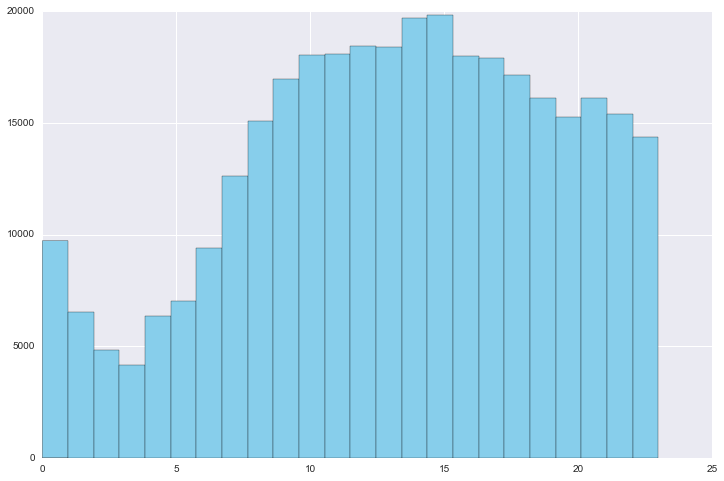

In [687]:
#overall service by hour of the day

hours = nyc_15['pickup_datetime'].dt.hour
hours.hist(bins = 24, color=["skyblue"], figsize=[12,8]);

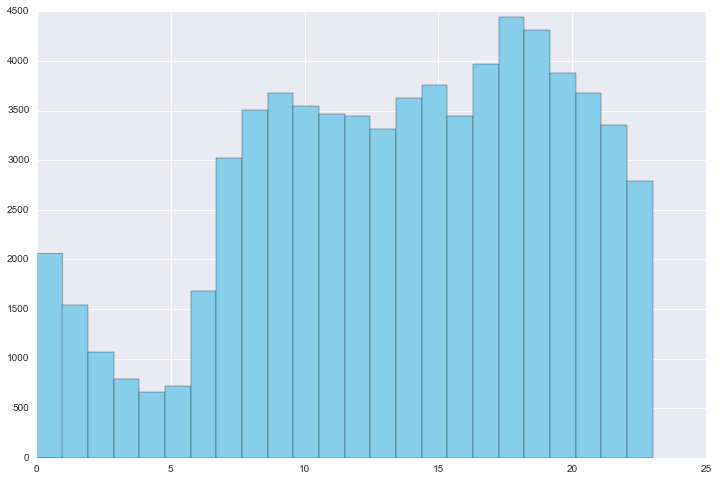

In [688]:
#Manhattan-Manhattan Service by hour of day

hours_m = Manhattan['pickup_datetime'].dt.hour
hours_m.hist(bins = 24, color=["skyblue"], figsize=[12,8]);

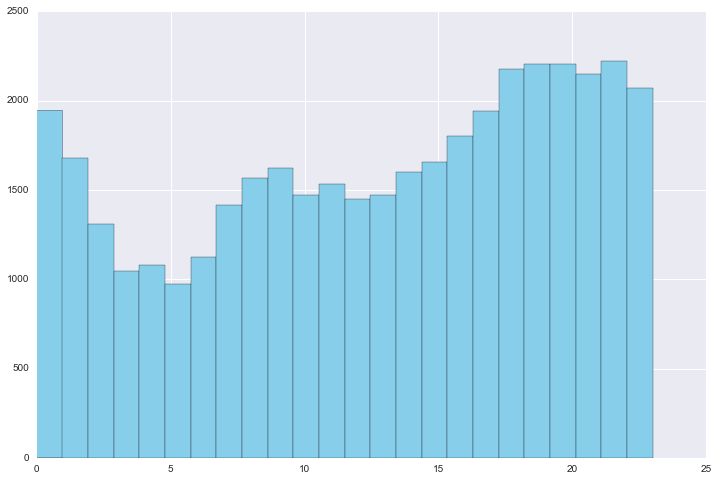

In [689]:
#Astoria-Astoria service by hour of the day, fewer passengers than in Manhattan but ridership
#is definitely more consistent and very popular in the evening and night from 6pm-1am

hours_a = AstoriaAstoria['pickup_datetime'].dt.hour
hours_a.hist(bins = 24, color=["skyblue"], figsize=[12,8]);

### Process and Questions:

I queried 2 samples from the LaGuardia/Astoria area 500,000 each of yellow and green taxis in 2015. And then I took smaller samples from Manhattan in the Upper East Side and Midtown areas 30,000 each of yellow and green taxis. With cloud computing or more time, I would take larger queries from more years of data, or even analyze the entire dataset as a whole to understand the totality of taxi behaviour. But for our purposes, this is sufficient and can be run locally.

I joined the SQL queries with NYC Open Data GeoJson shape files to eliminate rides in areas we weren’t interested in. Then I performed mathematical operations to determine efficiency, deleted errors, and subsetted the data into the geographical trips I was asked for

#### How would you assess the efficiency of aggregating rides within Astoria? From Astoria to Manhattan? From LaGuardia airport, through Astoria, to Manhattan and back?

#### How does this compare to rides within Manhattan?

#### Would you provide ride shares only within Astoria as new service or also between Astoria and Manhattan? Why?

#### Would you launch Astoria service during all our hours of operation (24/7) or only for certain hours? If so - which hours? 

The most distance-efficient place to aggregate rides is in Manhattan. But rides within Astoria, are still comparably distance-efficient, as are rides from Manhattan to Astoria and from LaGuardia to Manhattan. The least distance-efficient rides are from Manhattan to LaGuardia and Astoria to Manhattan.

Rides within Astoria are the least time-efficient, probably that’s because when you’re riding within Astoria you’re not riding on highways and the speed limit on city streets is 25 mph.  The second least time efficient ride is from Astoria to Manhattan. They are much less efficient than rides from Manhattan to Astoria. I’d be interested in examining traffic patterns for this reason. There is probably more traffic getting into Manhattan than there is traffic getting into Astoria. Rides within Manhattan are also relatively time inefficient, I’m guessing for the same reasons rides within Astoria are inefficient. Rides between Manhattan and LaGuardia are most time efficient, probably because more people travel off-peak to and from the Airport, and there’s more fast travel on a highway.

Riders in Astoria see considerably fewer passengers than in Manhattan, but ridership is more consistent and doesn’t see as sharp a drop from 2-6AM as in Manhattan and overall. I’d probably look at days of the week before deciding when to run the service. ~6pm-1am are peak ridership within Astoria, so that’s a great time range to capitalize on. I would also consider looking at late nights on the weekends until the bars close, and try it out on a pilot program. I don’t think i would start out with morning and daytime rides within Astoria, unless service was very limited. 

I'd provide rides only within Astoria, at least during peak hours, because it's relatively distance-efficient, but I'd need to look at overall ridership and financial information to make that determination. Also, rides from Astoria to Manhattan are among the least time and distance efficient, so I would probably avoid branching out into that area. 